In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForestModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
from darts.utils.utils import generate_index
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


COLORS = {
    'IHSG': '#2E7D32',
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'Inflation': '#D32F2F',
    'BI_Rate': '#F57C00',        
    'M2_YoY': '#1976D2',         
    'USDIDR': '#7B1FA2',         
    'NPL_Ratio': '#C2185B',      
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B']

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# line 
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# grid
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# legend
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

## Data Gathering and preprocessing

In [82]:
# data from bloomberg terminal
df = pd.read_csv('dataset/model1.csv')

# display basic info
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print("\n" + "="*60)
print("FIRST 10 ROWS")
print("="*60)
df.head(10)

DATA OVERVIEW
Shape: 121 rows × 7 columns

Columns: ['Date', 'IHSG', 'Inflation Rate YoY', 'Money Supply M2 YoY', 'USDIDR', 'BI Interest Rate', 'npl_ratio']

FIRST 10 ROWS


,Date,IHSG,Inflation Rate YoY,Money Supply M2 YoY,USDIDR,BI Interest Rate,npl_ratio
0,31/01/2025,7109.196,0.76,5.46,16300,5.75%,2.18%
1,31/12/2024,7079.905,1.57,4.76,16102,6.00%,2.08%
2,30/11/2024,7114.266,1.55,6.53,15845,6.00%,2.19%
3,31/10/2024,7574.019,1.71,6.77,15697,6.00%,2.20%
4,30/09/2024,7527.929,1.84,7.19,15140,6.00%,2.21%
5,31/08/2024,7670.733,2.12,7.30,15455,6.25%,2.26%
6,31/07/2024,7255.762,2.13,7.59,16260,6.25%,2.27%
7,30/06/2024,7063.577,2.51,7.67,16375,6.25%,2.26%
8,31/05/2024,6970.736,2.84,7.59,16250,6.25%,2.34%
9,30/04/2024,7234.197,3.00,6.87,16260,6.25%,2.33%


### Data Preprocessing

In [83]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 121 non-null    object 
 1   IHSG                 121 non-null    float64
 2   Inflation Rate YoY   121 non-null    float64
 3   Money Supply M2 YoY  121 non-null    float64
 4   USDIDR               121 non-null    int64  
 5   BI Interest Rate     121 non-null    object 
 6   npl_ratio            121 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 6.7+ KB

MISSING VALUES PER COLUMN
Date                   0
IHSG                   0
Inflation Rate YoY     0
Money Supply M2 YoY    0
USDIDR                 0
BI Interest Rate       0
npl_ratio              0
dtype: int64


In [84]:
df_clean = df.copy()

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d/%m/%Y')

pct_columns = ['BI Interest Rate', 'npl_ratio']
for col in pct_columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].str.replace('%', '').astype(float)

df_clean = df_clean.sort_values('Date').reset_index(drop=True)

df_clean.columns = ['Date', 'IHSG', 'Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']

print("="*60)
print("CLEANED DATA")
print("="*60)
print(f"Date Range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"Total Months: {len(df_clean)}")
print("\nData Types after cleaning:")
print(df_clean.dtypes)
print("\n")
df_clean.head(10)

CLEANED DATA
Date Range: 2015-01-31 00:00:00 to 2025-01-31 00:00:00
Total Months: 121

Data Types after cleaning:
Date             datetime64[ns]
IHSG                    float64
Inflation_YoY           float64
M2_YoY                  float64
USDIDR                    int64
BI_Rate                 float64
NPL_Ratio               float64
dtype: object




,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
0,2015-01-31,5289.404,6.96,14.31,12755,7.75,2.37
1,2015-02-28,5450.294,6.29,16.04,12928,7.50,2.43
2,2015-03-31,5518.675,6.38,16.26,13075,7.50,2.40
3,2015-04-30,5086.425,6.79,14.88,12964,7.50,2.48
4,2015-05-31,5216.379,7.15,13.42,13225,7.50,2.58
5,2015-06-30,4910.658,7.26,12.98,13333,7.50,2.56
6,2015-07-31,4802.529,7.26,12.50,13531,7.50,2.70
7,2015-08-31,4509.607,7.18,13.32,14053,7.50,2.76
8,2015-09-30,4223.908,6.83,12.43,14651,7.50,2.71
9,2015-10-31,4455.180,6.25,10.40,13695,7.50,2.68


In [85]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df_clean.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
count,121,121.00,121.00,121.00,121.00,121.00,121.00
mean,2020-01-30 02:58:30.743801600,6077.38,3.36,8.81,14363.80,5.25,2.77
min,2015-01-31 00:00:00,4223.91,0.76,3.35,12755.00,3.50,2.08
25%,2017-07-31 00:00:00,5386.69,2.48,6.77,13655.00,4.25,2.52
50%,2020-01-31 00:00:00,6056.12,3.18,8.18,14273.00,5.25,2.76
75%,2022-07-31 00:00:00,6843.24,3.83,10.53,14903.00,6.00,3.05
max,2025-01-31 00:00:00,7670.73,7.26,16.26,16375.00,7.75,3.35
std,NaN,850.61,1.49,2.74,895.79,1.24,0.32


## 4. Exploratory Data Analysis (EDA)

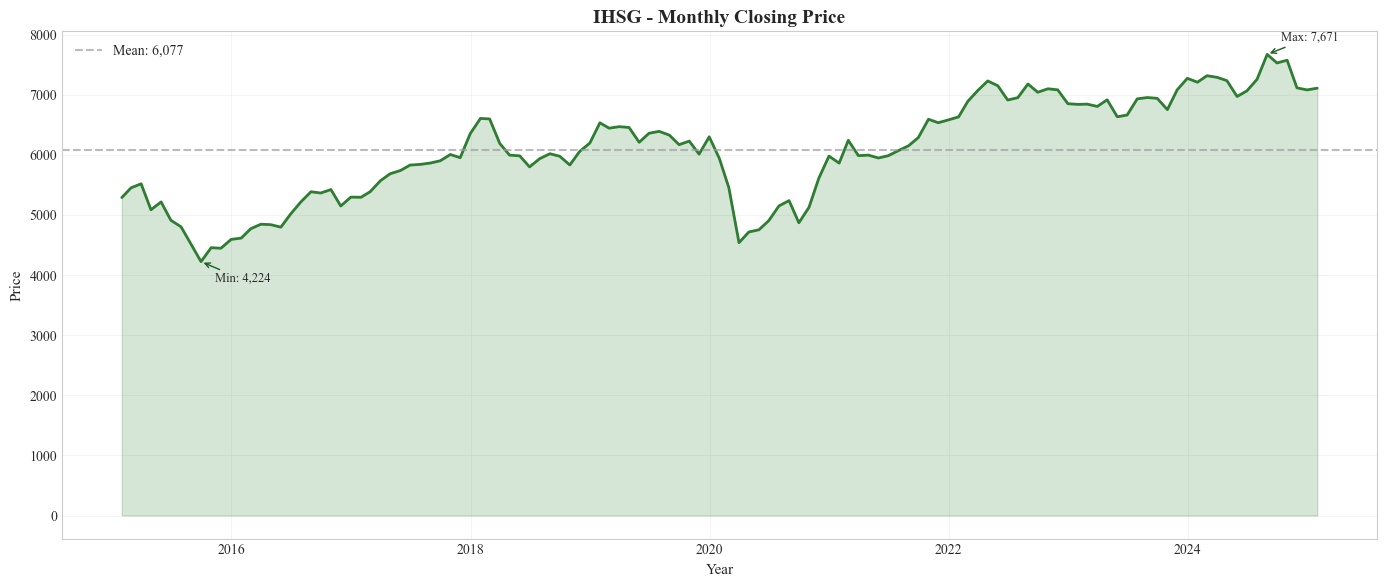

In [86]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_clean['Date'], df_clean['IHSG'], color=COLORS['IHSG'], linewidth=2)
ax.fill_between(df_clean['Date'], df_clean['IHSG'], alpha=0.2, color=COLORS['IHSG'])

# Add mean line
ihsg_mean = df_clean['IHSG'].mean()
ax.axhline(y=ihsg_mean, color=COLORS['error'], linestyle='--', alpha=0.7, 
           label=f'Mean: {ihsg_mean:,.0f}')

ax.set_title('IHSG - Monthly Closing Price', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add annotations for min/max
ihsg_max_idx = df_clean['IHSG'].idxmax()
ihsg_min_idx = df_clean['IHSG'].idxmin()
ax.annotate(f"Max: {df_clean.loc[ihsg_max_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_max_idx, 'Date'], df_clean.loc[ihsg_max_idx, 'IHSG']),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))
ax.annotate(f"Min: {df_clean.loc[ihsg_min_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_min_idx, 'Date'], df_clean.loc[ihsg_min_idx, 'IHSG']),
            xytext=(10, -15), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))

plt.tight_layout()
plt.savefig('model1-figure/eda_ihsg.png', dpi=300, bbox_inches='tight')
plt.show()

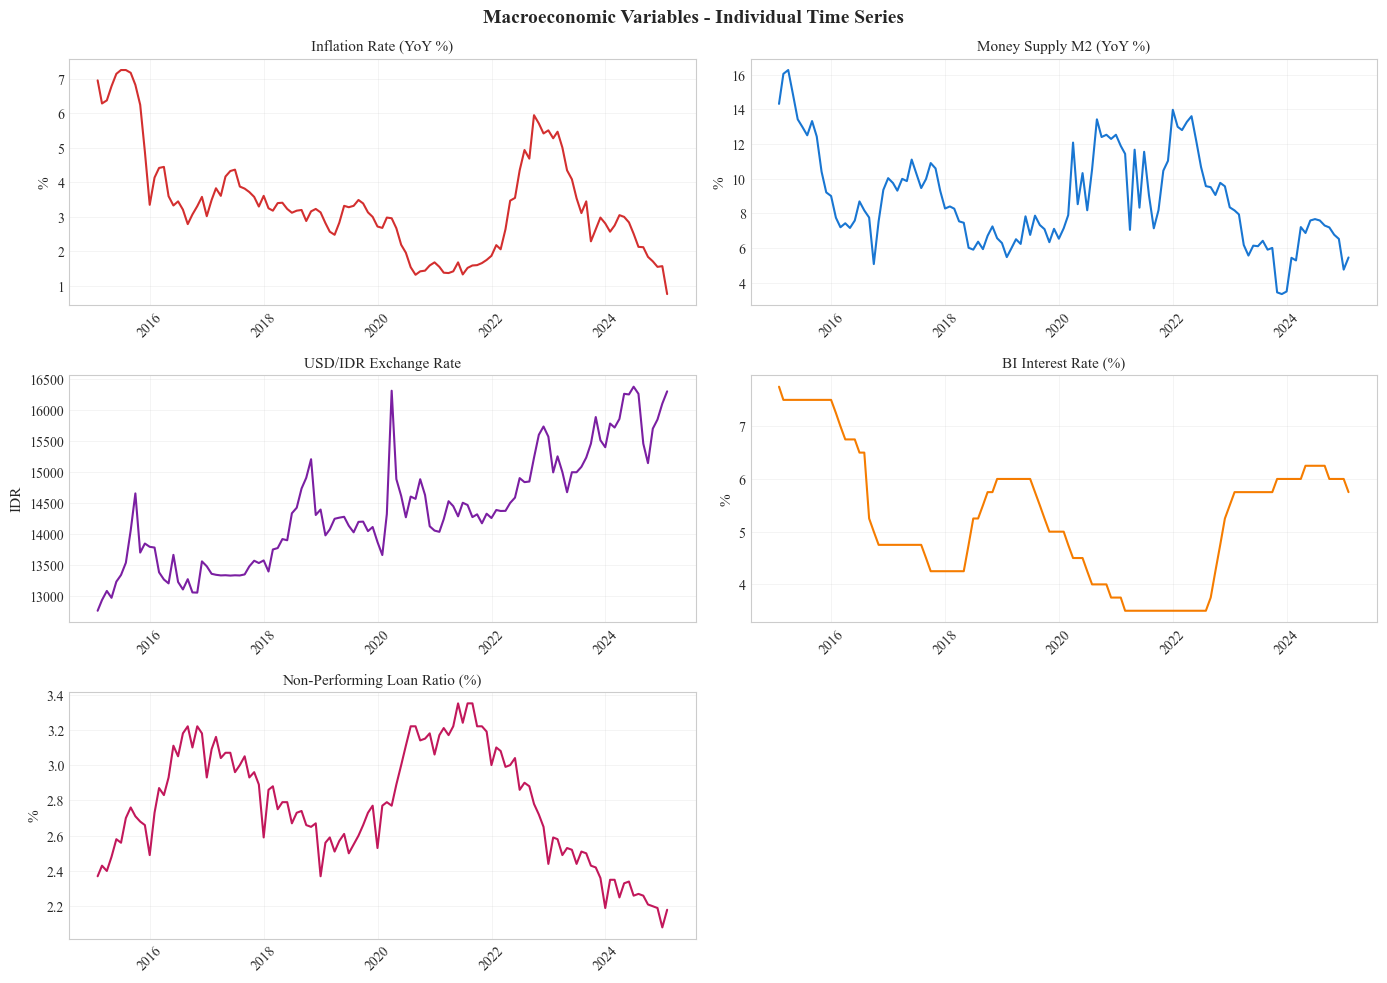

In [87]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Macroeconomic Variables - Individual Time Series', fontsize=14, fontweight='bold')

plot_config = [
    ('Inflation_YoY', COLORS['Inflation'], 'Inflation Rate (YoY %)', '%'),
    ('M2_YoY', COLORS['M2_YoY'], 'Money Supply M2 (YoY %)', '%'),
    ('USDIDR', COLORS['USDIDR'], 'USD/IDR Exchange Rate', 'IDR'),
    ('BI_Rate', COLORS['BI_Rate'], 'BI Interest Rate (%)', '%'),
    ('NPL_Ratio', COLORS['NPL_Ratio'], 'Non-Performing Loan Ratio (%)', '%'),
]

for idx, (col, color, title, ylabel) in enumerate(plot_config):
    ax = axes[idx // 2, idx % 2]
    ax.plot(df_clean['Date'], df_clean[col], color=color, linewidth=1.5)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Hide the last empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.savefig('model1-figure/eda_covariates_individual.png', dpi=300, bbox_inches='tight')
plt.show()

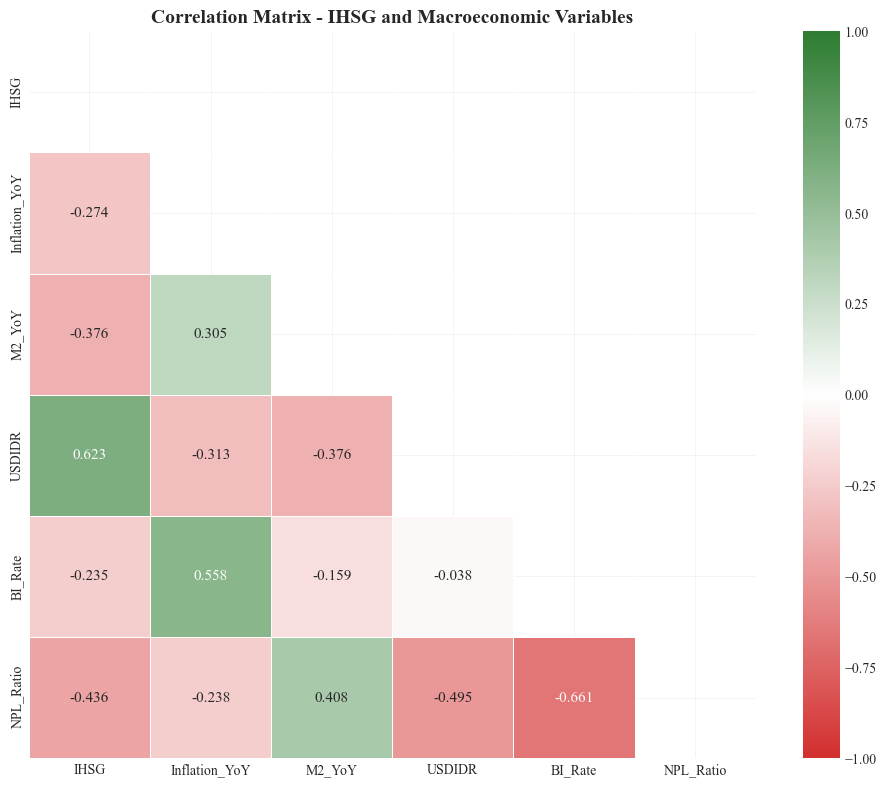

✅ Figure saved: model1-figure/correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
USDIDR          : +0.6227 (Moderate ↑ Positive)
BI_Rate         : -0.2353 (Weak ↓ Negative)
Inflation_YoY   : -0.2740 (Weak ↓ Negative)
M2_YoY          : -0.3763 (Weak ↓ Negative)
NPL_Ratio       : -0.4360 (Moderate ↓ Negative)


In [88]:
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df_clean.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 11}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG and Macroeconomic Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model1-figure/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/correlation_matrix.png (300 DPI)")
print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "↑ Positive" if corr > 0 else "↓ Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## 5. Create Darts TimeSeries Objects

In [89]:
IHSG_series = TimeSeries.from_dataframe(df_clean, time_col='Date', value_cols='IHSG', freq='ME')
COVAR_series = TimeSeries.from_dataframe(df_clean, time_col='Date', value_cols=['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio'], freq='ME')

In [90]:
train_ratio = 0.8
split_point = int(len(IHSG_series) * train_ratio)

ihsg_train = IHSG_series[:split_point]
ihsg_test = IHSG_series[split_point:]

covar_train = COVAR_series[:split_point]
covar_test = COVAR_series[split_point:]

<Axes: xlabel='Date'>

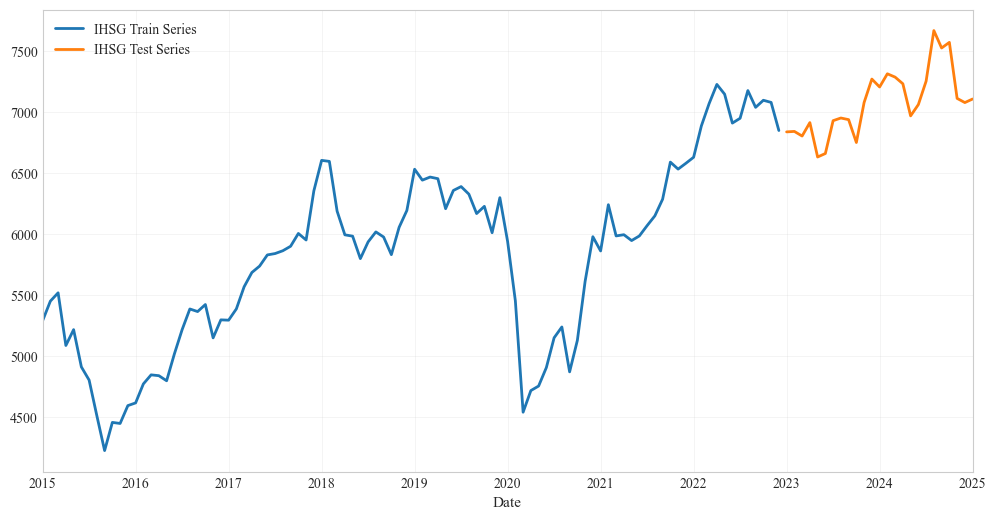

In [91]:
ihsg_train.plot(label='IHSG Train Series')
ihsg_test.plot(label='IHSG Test Series')

In [92]:
ihsg_train

,IHSG
Date,
2015-01-31,5289.404
2015-02-28,5450.294
2015-03-31,5518.675
2015-04-30,5086.425
2015-05-31,5216.379
...,...
2022-08-31,7178.590
2022-09-30,7040.798
2022-10-31,7098.890


In [93]:
print("DARTS TIMESERIES")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {IHSG_series.start_time()}")
print(f"  - End: {IHSG_series.end_time()}")
print(f"  - Length: {len(IHSG_series)} time steps")
print(f"  - Frequency: {IHSG_series.freq}")
print(f"\nCovariates:")
print(f"  - Components: {COVAR_series.components.tolist()}")
print(f"  - Length: {len(COVAR_series)} time steps")

DARTS TIMESERIES
Target Series (IHSG):
  - Start: 2015-01-31 00:00:00
  - End: 2025-01-31 00:00:00
  - Length: 121 time steps
  - Frequency: <MonthEnd>

Covariates:
  - Components: ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']
  - Length: 121 time steps


## 6. Train/Test Split and Scaling

In [94]:
from darts.dataprocessing.transformers import Scaler

scaler_ihsg = Scaler(MinMaxScaler(feature_range=(-1, 1)))

ihsg_train_scaled = scaler_ihsg.fit_transform(ihsg_train)
ihsg_test_scaled = scaler_ihsg.transform(ihsg_test)

scaler_covar = Scaler(MinMaxScaler(feature_range=(-1, 1)))

covar_train_scaled = scaler_covar.fit_transform(covar_train)
covar_test_scaled = scaler_covar.transform(covar_test)

covar_full_scaled = covar_train_scaled.append(covar_test_scaled)

# =====================================================
# VERIFIKASI TIDAK ADA LEAKAGE
# =====================================================
print("="*60)
print("DATA LEAKAGE CHECK")
print("="*60)
print(f"Train Target: {ihsg_train_scaled.start_time()} → {ihsg_train_scaled.end_time()}")
print(f"Train Cov:    {covar_train_scaled.start_time()} → {covar_train_scaled.end_time()}")
print(f"Test Target:  {ihsg_test_scaled.start_time()} → {ihsg_test_scaled.end_time()}")
print(f"Test Cov:     {covar_test_scaled.start_time()} → {covar_test_scaled.end_time()}")

# Pastikan train periods match
assert ihsg_train_scaled.end_time() == covar_train_scaled.end_time(), \
    "ERROR: Train target dan covariates tidak sinkron!"
print("\n✓ No data leakage detected in split")

DATA LEAKAGE CHECK
Train Target: 2015-01-31 00:00:00 → 2022-12-31 00:00:00
Train Cov:    2015-01-31 00:00:00 → 2022-12-31 00:00:00
Test Target:  2023-01-31 00:00:00 → 2025-01-31 00:00:00
Test Cov:     2023-01-31 00:00:00 → 2025-01-31 00:00:00

✓ No data leakage detected in split


## 7. Hyperparameter Tuning with Optuna

In [95]:
OUTPUT_CHUNK_LENGTH = 1

# hyperparameter tuning gridsearch

param_grid = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],       
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 7, None],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],        
}
    
print("\nGridSearch Parameters:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to evaluate: {total_combinations}")



GridSearch Parameters:
  lags: [1, 3, 6, 12]
  lags_past_covariates: [1, 3, 6, 12]
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7, None]
  max_features: [None, 'sqrt', 'log2']
  bootstrap: [True, False]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Total combinations to evaluate: 10368


In [96]:
best_model, best_params, best_score = RandomForestModel.gridsearch(
    parameters=param_grid,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 15.9981%

Best Hyperparameters:
  lags: 6
  lags_past_covariates: 3
  n_estimators: 200
  max_depth: 5
  max_features: None
  bootstrap: True
  min_samples_split: 5
  min_samples_leaf: 4


In [97]:
final_model = RandomForestModel(
    lags=best_params['lags'],
    lags_past_covariates=best_params['lags_past_covariates'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

In [98]:
final_model.fit(
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

RandomForestModel(lags=6, lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=200, max_depth=5, multi_models=True, use_static_covariates=True, random_state=42, max_features=None, bootstrap=True, min_samples_split=5, min_samples_leaf=4, n_jobs=-1)

In [99]:
forecast = final_model.predict(
    n=len(ihsg_test_scaled),
    past_covariates=covar_full_scaled
)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [100]:
from darts.metrics import mape

test_mape = mape(ihsg_test_scaled, forecast)
print(f"Test MAPE: {test_mape:.4f}%")


Test MAPE: 16.0879%


In [101]:
ihsg_full_scaled = ihsg_train_scaled.append(ihsg_test_scaled)

final_model.fit(
    series=ihsg_full_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)


RandomForestModel(lags=6, lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=200, max_depth=5, multi_models=True, use_static_covariates=True, random_state=42, max_features=None, bootstrap=True, min_samples_split=5, min_samples_leaf=4, n_jobs=-1)

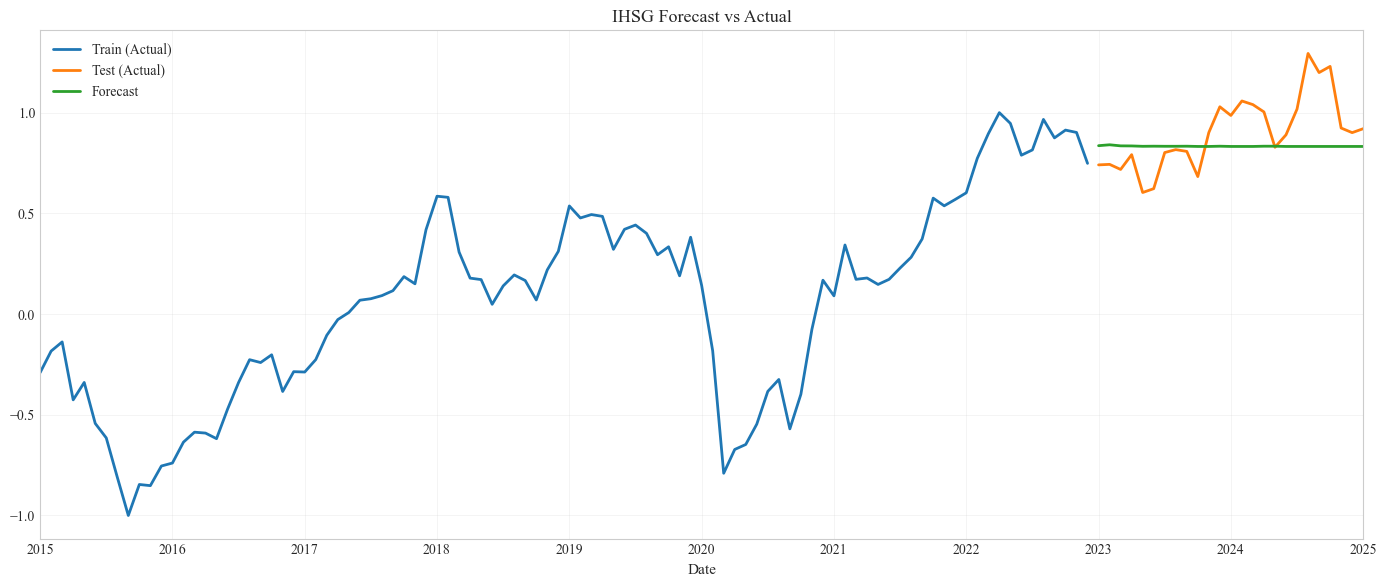

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# actual
ihsg_train_scaled.plot(label="Train (Actual)")
ihsg_test_scaled.plot(label="Test (Actual)")

# forecast
forecast.plot(label="Forecast", linewidth=2)

plt.title("IHSG Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


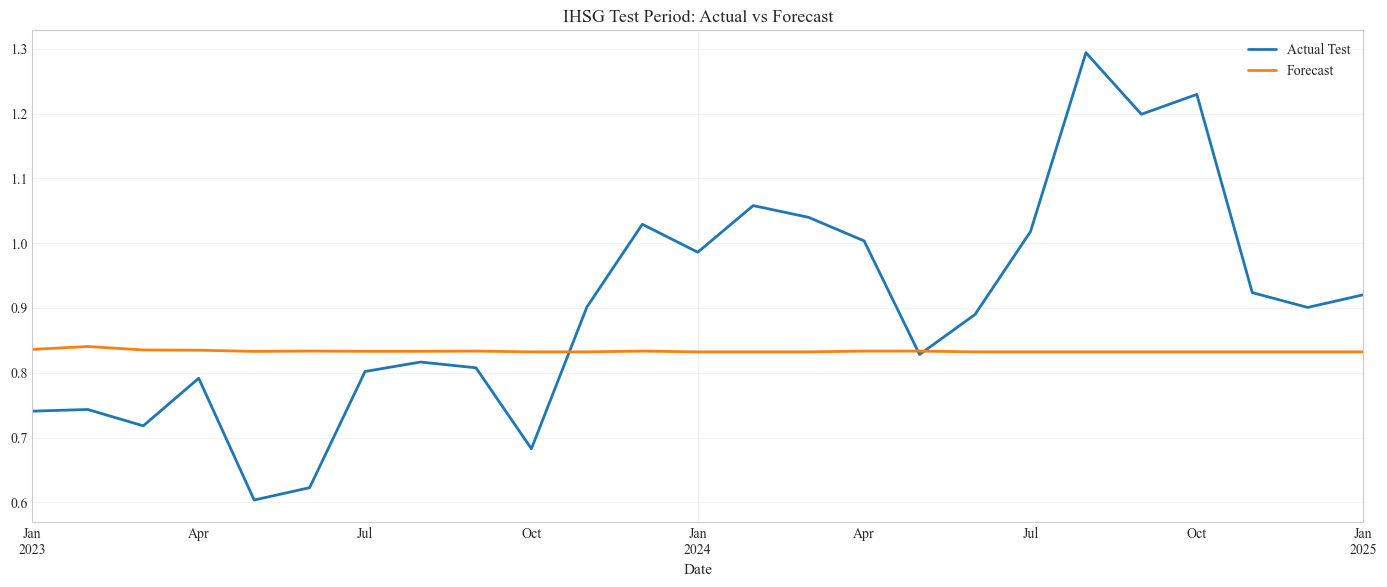

In [103]:
plt.figure(figsize=(14, 6))

ihsg_test_scaled.plot(label="Actual Test")
forecast.plot(label="Forecast", linewidth=2)

plt.title("IHSG Test Period: Actual vs Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Train Best Model and Generate Predictions

In [107]:
# Generate 1-step-ahead predictions using historical_forecasts
# This simulates real-world scenario: predict month t+1, then move forward

predictions_scaled = final_model.historical_forecasts(
    series=ihsg_full_scaled,
    past_covariates=covar_full_scaled,
    start=ihsg_test_scaled.start_time(),
    forecast_horizon=1,  # 1 month ahead
    stride=1,            # Move 1 step each time
    retrain=False,       # Use the trained model without retraining
    verbose=True
)

predictions = scaler_ihsg.inverse_transform(predictions_scaled)
test_actual = scaler_ihsg.inverse_transform(ihsg_test_scaled)

print("="*60)
print("PREDICTIONS GENERATED (1-Step-Ahead)")
print("="*60)
print(f"Prediction Period: {predictions.start_time()} to {predictions.end_time()}")
print(f"Number of predictions: {len(predictions)}")
print(f"Forecast Method: Rolling 1-month-ahead forecast")

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

PREDICTIONS GENERATED (1-Step-Ahead)
Prediction Period: 2023-01-31 00:00:00 to 2025-01-31 00:00:00
Number of predictions: 25
Forecast Method: Rolling 1-month-ahead forecast


## 9. Model Evaluation

In [108]:
# Calculate evaluation metrics
mape_score = mape(test_actual, predictions)
rmse_score = rmse(test_actual, predictions)
mae_score = mae(test_actual, predictions)
r2 = r2_score(test_actual, predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"MAPE (Mean Absolute Percentage Error): {mape_score:.4f}%")
print(f"RMSE (Root Mean Square Error):         {rmse_score:.4f}")
print(f"MAE (Mean Absolute Error):             {mae_score:.4f}")
print(f"R² Score:                              {r2:.4f}")
print("="*60)

# Interpretation
print("\n📊 INTERPRETATION:")
if mape_score < 5:
    print(f"  ✅ MAPE < 5%: Excellent forecasting accuracy")
elif mape_score < 10:
    print(f"  ✅ MAPE < 10%: Good forecasting accuracy")
elif mape_score < 20:
    print(f"  ⚠️ MAPE < 20%: Reasonable forecasting accuracy")
else:
    print(f"  ❌ MAPE > 20%: Poor forecasting accuracy")

MODEL EVALUATION METRICS
MAPE (Mean Absolute Percentage Error): 1.1443%
RMSE (Root Mean Square Error):         105.7583
MAE (Mean Absolute Error):             81.9661
R² Score:                              0.8422

📊 INTERPRETATION:
  ✅ MAPE < 5%: Excellent forecasting accuracy


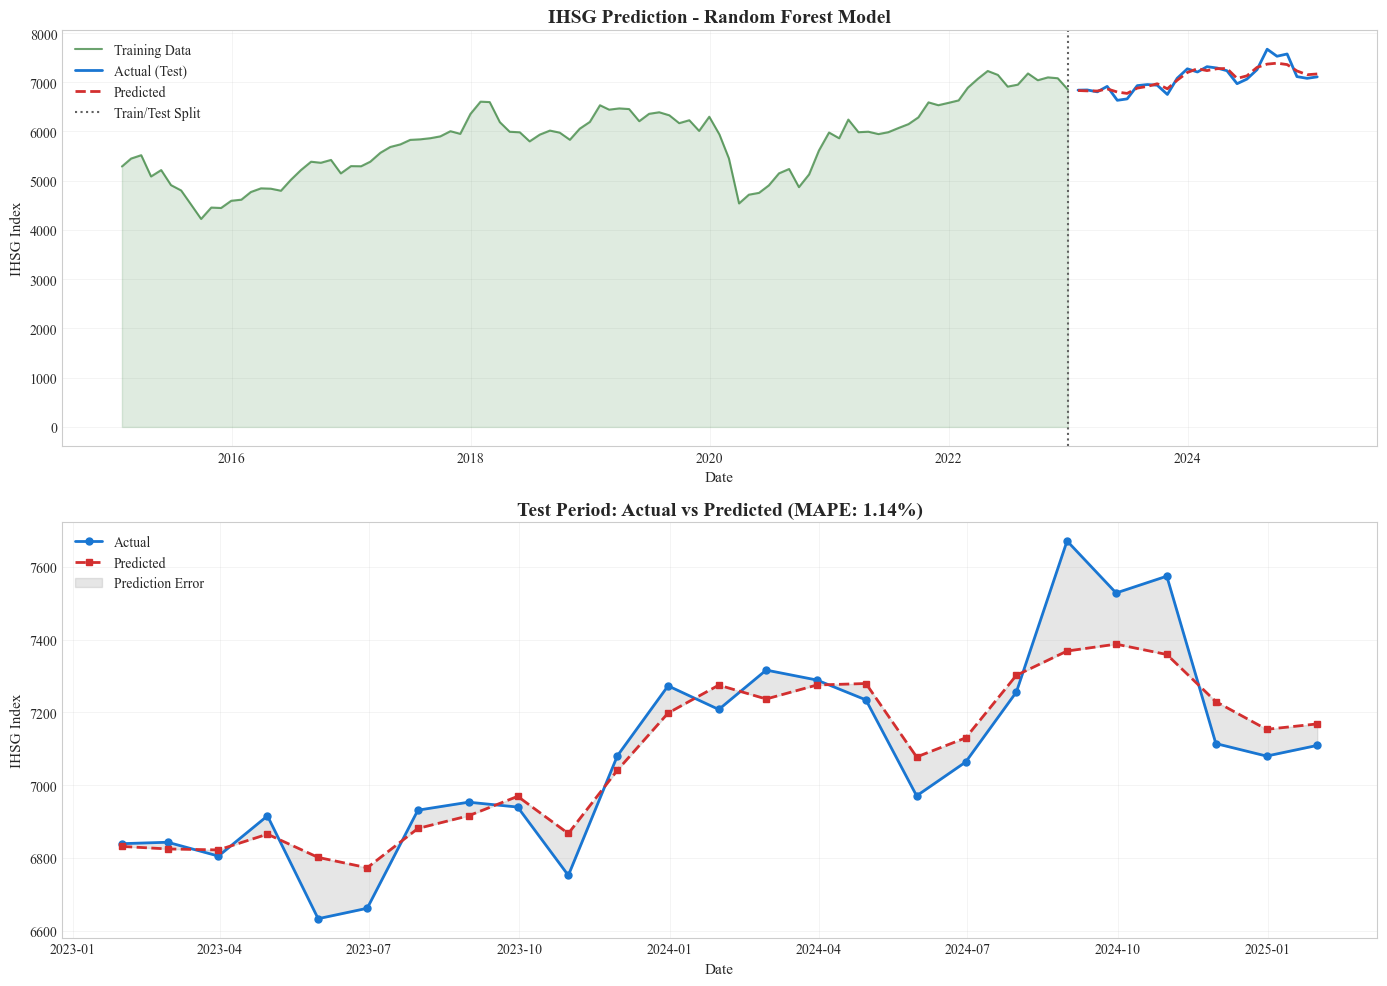

✅ Figure saved: model1-figure/prediction_results.png (300 DPI)


In [109]:
# Visualization: Actual vs Predicted with thesis color palette
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full time series with predictions
ax1 = axes[0]
ax1.plot(ihsg_train.time_index, ihsg_train.values(), 
         label='Training Data', color=COLORS['train'], linewidth=1.5, alpha=0.7)
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual (Test)', color=COLORS['actual'], linewidth=2)
ax1.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=2, linestyle='--')
ax1.axvline(x=ihsg_train.end_time(), color=COLORS['split_line'], linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.fill_between(ihsg_train.time_index, ihsg_train.values().flatten(), alpha=0.15, color=COLORS['train'])
ax1.set_title('IHSG Prediction - Random Forest Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Test period close-up
ax2 = axes[1]
ax2.plot(test_actual.time_index, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=2, marker='o', markersize=5)
ax2.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=2, linestyle='--', marker='s', markersize=5)
ax2.fill_between(test_actual.time_index, 
                  test_actual.values().flatten(), 
                  predictions.values().flatten(), 
                  alpha=0.25, color=COLORS['error'], label='Prediction Error')
ax2.set_title(f'Test Period: Actual vs Predicted (MAPE: {mape_score:.2f}%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('IHSG Index')
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model1-figure/prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/prediction_results.png (300 DPI)")

## 10. Feature Importance with SHAP

In [110]:
COVARIATE_COLS = ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']

rf_estimator = final_model.model.estimators_[0]

# Prepare feature matrix for SHAP
# We need to reconstruct the lagged features that the model uses
lags = best_params['lags']
lags_cov = best_params['lags_past_covariates']

# Create lagged feature dataframe
def create_lagged_features(target_df, cov_df, target_lags, cov_lags):
    """Create lagged features for SHAP analysis"""
    features = pd.DataFrame(index=target_df.index[max(target_lags, cov_lags):])
    
    # Target lags
    for lag in range(1, target_lags + 1):
        features[f'IHSG_lag{lag}'] = target_df['IHSG'].shift(lag).values[max(target_lags, cov_lags):]
    
    # Covariate lags
    for col in cov_df.columns:
        for lag in range(1, cov_lags + 1):
            features[f'{col}_lag{lag}'] = cov_df[col].shift(lag).values[max(target_lags, cov_lags):]
    
    return features.dropna()

# Prepare data
target_df = df_clean.set_index('Date')[['IHSG']]
cov_df = df_clean.set_index('Date')[COVARIATE_COLS]

X_features = create_lagged_features(target_df, cov_df, lags, lags_cov)

print("="*60)
print("FEATURE MATRIX FOR SHAP")
print("="*60)
print(f"Feature matrix shape: {X_features.shape}")
print(f"\nFeatures ({len(X_features.columns)}):")
for i, col in enumerate(X_features.columns, 1):
    print(f"  {i}. {col}")

FEATURE MATRIX FOR SHAP
Feature matrix shape: (115, 21)

Features (21):
  1. IHSG_lag1
  2. IHSG_lag2
  3. IHSG_lag3
  4. IHSG_lag4
  5. IHSG_lag5
  6. IHSG_lag6
  7. Inflation_YoY_lag1
  8. Inflation_YoY_lag2
  9. Inflation_YoY_lag3
  10. M2_YoY_lag1
  11. M2_YoY_lag2
  12. M2_YoY_lag3
  13. USDIDR_lag1
  14. USDIDR_lag2
  15. USDIDR_lag3
  16. BI_Rate_lag1
  17. BI_Rate_lag2
  18. BI_Rate_lag3
  19. NPL_Ratio_lag1
  20. NPL_Ratio_lag2
  21. NPL_Ratio_lag3


In [111]:
# Train a standalone RandomForest model for SHAP analysis
from sklearn.ensemble import RandomForestRegressor

# Prepare target (shifted to align with features)
y_target = target_df['IHSG'].values[max(lags, lags_cov) + 1:]  # +1 for next month prediction
X_train = X_features.iloc[:-1].values  # Remove last row to match y_target length

# Ensure alignment
min_len = min(len(X_train), len(y_target))
X_train = X_train[:min_len]
y_target = y_target[:min_len]

# Train RF model for SHAP
rf_shap = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42,
    n_jobs=-1
)
rf_shap.fit(X_train, y_target)

print("="*60)
print("RANDOM FOREST FOR SHAP ANALYSIS")
print("="*60)
print(f"Model fitted on {X_train.shape[0]} samples with {X_train.shape[1]} features")
print(f"R² Score: {rf_shap.score(X_train, y_target):.4f}")

RANDOM FOREST FOR SHAP ANALYSIS
Model fitted on 114 samples with 21 features
R² Score: 0.9784


In [112]:
# SHAP Analysis
print("="*60)
print("COMPUTING SHAP VALUES (this may take a moment...)")
print("="*60)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_shap)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Create DataFrame with feature names
X_train_df = pd.DataFrame(X_train, columns=X_features.columns[:-1] if len(X_features.columns) > X_train.shape[1] else X_features.columns[:X_train.shape[1]])

print("✅ SHAP values computed successfully!")

COMPUTING SHAP VALUES (this may take a moment...)
✅ SHAP values computed successfully!


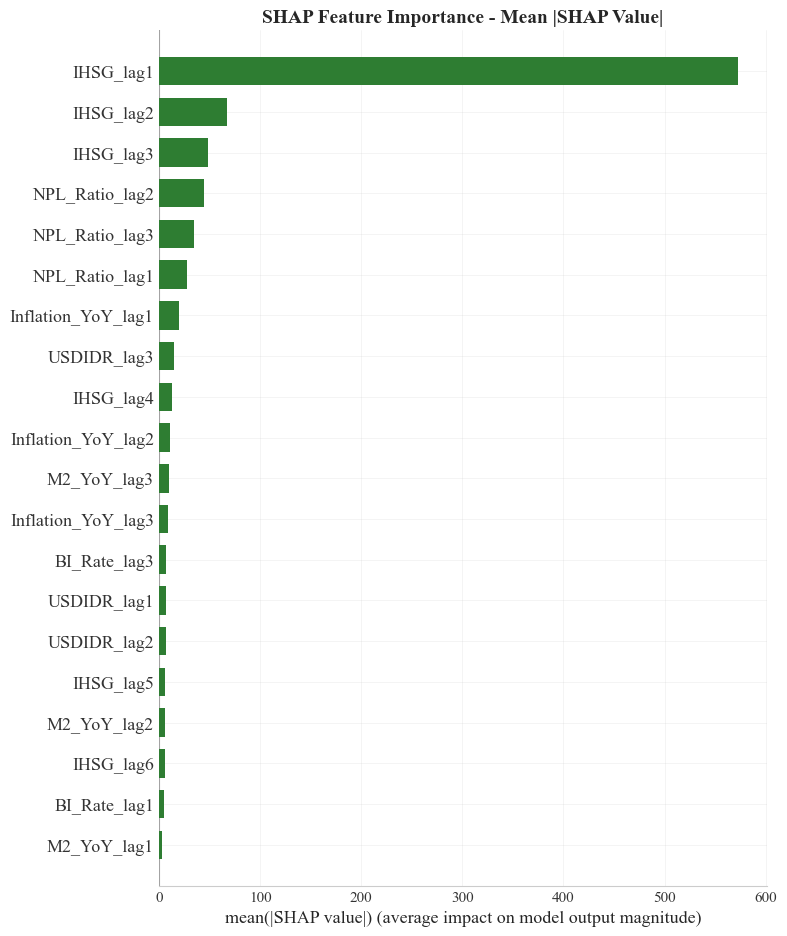

✅ Figure saved: model1-figure/shap_importance_bar.png (300 DPI)


In [113]:
# SHAP Summary Plot (Bar)
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_df, plot_type="bar", show=False, color=COLORS['IHSG'])
plt.title('SHAP Feature Importance - Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model1-figure/shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/shap_importance_bar.png (300 DPI)")

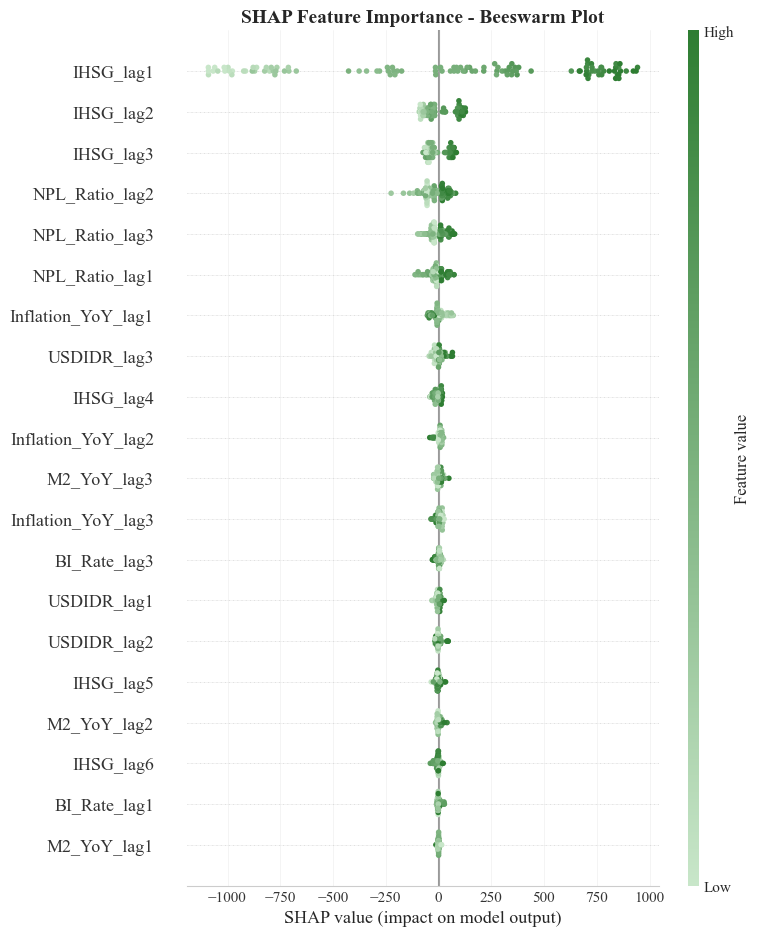

✅ Figure saved: model1-figure/shap_importance_beeswarm.png (300 DPI)


In [114]:
# SHAP Summary Plot (Beeswarm) with custom colormap
fig, ax = plt.subplots(figsize=(12, 10))

# Custom colormap for SHAP beeswarm (Green gradient)
from matplotlib.colors import LinearSegmentedColormap
shap_cmap = LinearSegmentedColormap.from_list('shap_green', ['#C8E6C9', '#2E7D32'], N=256)

shap.summary_plot(shap_values, X_train_df, show=False, cmap=shap_cmap)
plt.title('SHAP Feature Importance - Beeswarm Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model1-figure/shap_importance_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/shap_importance_beeswarm.png (300 DPI)")

In [115]:
# Calculate aggregated feature importance by variable (not by lag)
feature_importance_by_var = {}

for col in X_train_df.columns:
    # Extract variable name (remove lag suffix)
    if '_lag' in col:
        var_name = col.rsplit('_lag', 1)[0]
    else:
        var_name = col
    
    col_idx = list(X_train_df.columns).index(col)
    importance = np.abs(shap_values[:, col_idx]).mean()
    
    if var_name not in feature_importance_by_var:
        feature_importance_by_var[var_name] = 0
    feature_importance_by_var[var_name] += importance

# Sort by importance
sorted_importance = dict(sorted(feature_importance_by_var.items(), key=lambda x: x[1], reverse=True))

print("="*60)
print("AGGREGATED FEATURE IMPORTANCE BY VARIABLE")
print("="*60)
total_importance = sum(sorted_importance.values())
for var, importance in sorted_importance.items():
    pct = (importance / total_importance) * 100
    bar = "█" * int(pct / 2)
    print(f"{var:15} : {importance:8.4f} ({pct:5.2f}%) {bar}")

AGGREGATED FEATURE IMPORTANCE BY VARIABLE
IHSG            : 712.1344 (77.61%) ██████████████████████████████████████
NPL_Ratio       : 106.1503 (11.57%) █████
Inflation_YoY   :  38.6924 ( 4.22%) ██
USDIDR          :  28.0264 ( 3.05%) █
M2_YoY          :  18.0485 ( 1.97%) 
BI_Rate         :  14.5146 ( 1.58%) 


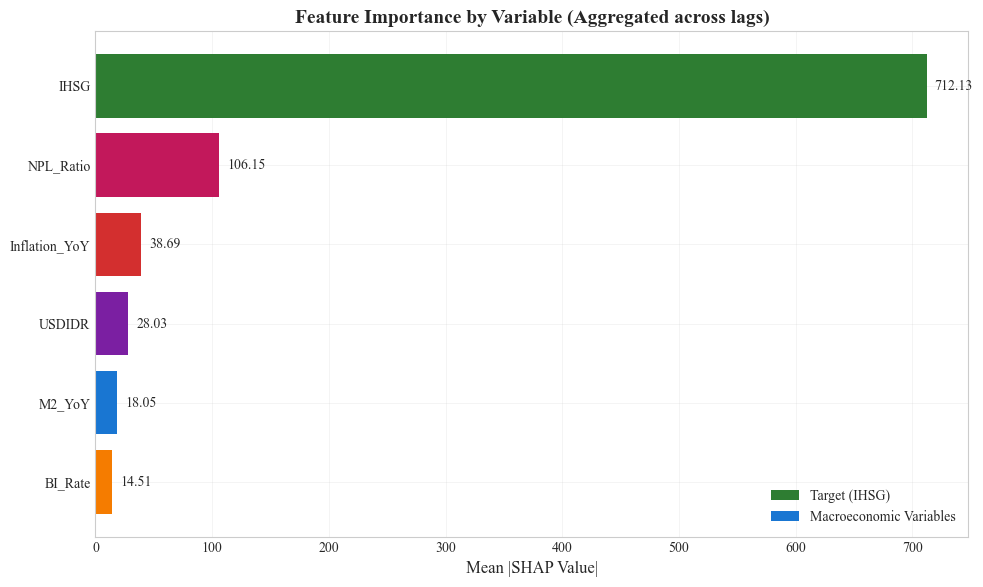

✅ Figure saved: model1-figure/feature_importance_aggregated.png (300 DPI)


In [116]:
# Visualization: Aggregated Feature Importance with thesis colors
fig, ax = plt.subplots(figsize=(10, 6))

vars_names = list(sorted_importance.keys())
importances = list(sorted_importance.values())

# Color coding: IHSG = Green (primary), Macroeconomic = use palette
bar_colors = []
for v in vars_names:
    if 'IHSG' in v:
        bar_colors.append(COLORS['IHSG'])
    elif 'Inflation' in v:
        bar_colors.append(COLORS['Inflation'])
    elif 'M2' in v:
        bar_colors.append(COLORS['M2_YoY'])
    elif 'USDIDR' in v:
        bar_colors.append(COLORS['USDIDR'])
    elif 'BI_Rate' in v:
        bar_colors.append(COLORS['BI_Rate'])
    elif 'NPL' in v:
        bar_colors.append(COLORS['NPL_Ratio'])
    else:
        bar_colors.append(COLORS['error'])

bars = ax.barh(vars_names[::-1], importances[::-1], color=bar_colors[::-1])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance by Variable (Aggregated across lags)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, importances[::-1]):
    ax.text(val + max(importances)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['IHSG'], label='Target (IHSG)'),
    Patch(facecolor=COLORS['M2_YoY'], label='Macroeconomic Variables')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig('model1-figure/feature_importance_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/feature_importance_aggregated.png (300 DPI)")

## 11. Results Summary

In [118]:
# Final Summary
print("="*70)
print("HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI")
print("="*70)

print("\n📊 DATA:")
print(f"   • Periode Data     : {df_clean['Date'].min().strftime('%B %Y')} - {df_clean['Date'].max().strftime('%B %Y')}")
print(f"   • Total Observasi  : {len(df_clean)} bulan")
print(f"   • Train/Test Split : {train_ratio*100:.0f}% / {(1-train_ratio)*100:.0f}%")

print("\n🎯 TARGET:")
print(f"   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)")

print("\n📈 COVARIATES (Variabel Makroekonomi):")
for i, col in enumerate(COVARIATE_COLS, 1):
    print(f"   {i}. {col}")

print("\n⚙️ BEST HYPERPARAMETERS (via GridSearch):")
for param, value in best_params.items():
    print(f"   • {param}: {value}")

print("\n📏 MODEL PERFORMANCE:")
print(f"   • MAPE  : {mape_score:.4f}%")
print(f"   • RMSE  : {rmse_score:.4f}")
print(f"   • MAE   : {mae_score:.4f}")
print(f"   • R²    : {r2:.4f}")

print("\n🔍 FEATURE IMPORTANCE (SHAP - Top 3):")
for i, (var, imp) in enumerate(list(sorted_importance.items())[:3], 1):
    pct = (imp / total_importance) * 100
    print(f"   {i}. {var}: {pct:.2f}%")

print("\n" + "="*70)
print("Source: Author's calculation, 2025")
print("="*70)

HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI

📊 DATA:
   • Periode Data     : January 2015 - January 2025
   • Total Observasi  : 121 bulan
   • Train/Test Split : 80% / 20%

🎯 TARGET:
   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)

📈 COVARIATES (Variabel Makroekonomi):
   1. Inflation_YoY
   2. M2_YoY
   3. USDIDR
   4. BI_Rate
   5. NPL_Ratio

⚙️ BEST HYPERPARAMETERS (via GridSearch):
   • lags: 6
   • lags_past_covariates: 3
   • n_estimators: 200
   • max_depth: 5
   • max_features: None
   • bootstrap: True
   • min_samples_split: 5
   • min_samples_leaf: 4

📏 MODEL PERFORMANCE:
   • MAPE  : 1.1443%
   • RMSE  : 105.7583
   • MAE   : 81.9661
   • R²    : 0.8422

🔍 FEATURE IMPORTANCE (SHAP - Top 3):
   1. IHSG: 77.61%
   2. NPL_Ratio: 11.57%
   3. Inflation_YoY: 4.22%

Source: Author's calculation, 2025


In [119]:
# Save results to CSV
results_df = pd.DataFrame({
    'Date': test_actual.time_index,
    'Actual_IHSG': test_actual.values().flatten(),
    'Predicted_IHSG': predictions.values().flatten(),
    'Error': (predictions.values().flatten() - test_actual.values().flatten()),
    'APE_%': np.abs((predictions.values().flatten() - test_actual.values().flatten()) / test_actual.values().flatten()) * 100
})

results_df.to_csv('model1_predictions.csv', index=False)
print("✅ Predictions saved to 'model1_predictions.csv'")

# Display prediction results
results_df.round(2)

✅ Predictions saved to 'model1_predictions.csv'


,Date,Actual_IHSG,Predicted_IHSG,Error,APE_%
0,2023-01-31,6839.34,6831.71,-7.63,0.11
1,2023-02-28,6843.24,6824.87,-18.37,0.27
2,2023-03-31,6805.28,6822.16,16.88,0.25
3,2023-04-30,6915.72,6865.47,-50.24,0.73
4,2023-05-31,6633.26,6801.62,168.36,2.54
5,2023-06-30,6661.88,6773.24,111.36,1.67
6,2023-07-31,6931.36,6881.12,-50.24,0.72
7,2023-08-31,6953.26,6915.96,-37.30,0.54
8,2023-09-30,6939.89,6969.30,29.41,0.42
9,2023-10-31,6752.21,6867.27,115.06,1.70


## 12. Benchmark: XGBoost Model

In [125]:
# Import XGBoost model from darts
from darts.models import XGBModel

param_grid_xgb = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],       
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 7, None],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [126]:
best_model_xgb, best_params_xgb, best_score_xgb = XGBModel.gridsearch(
    parameters=param_grid_xgb,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score_xgb:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params_xgb.items():
    print(f"  {param}: {value}")

gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 16.5189%

Best Hyperparameters:
  lags: 6
  lags_past_covariates: 3
  n_estimators: 50
  max_depth: 7
  learning_rate: 0.05
  subsample: 1.0
  colsample_bytree: 1.0


In [127]:

xgb_final_model = XGBModel(
    lags=best_params_xgb['lags'],
    lags_past_covariates=best_params_xgb['lags_past_covariates'],
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    random_state=42,
    verbosity=0
)

In [129]:
xgb_final_model.fit(
    series=ihsg_full_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

XGBModel(lags=6, lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=50, max_depth=7, learning_rate=0.05, subsample=1.0, colsample_bytree=1.0, verbosity=0)

In [130]:
xgb_predictions_scaled = xgb_final_model.historical_forecasts(
    series=ihsg_full_scaled,
    past_covariates=covar_full_scaled,
    start=ihsg_test_scaled.start_time(),
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True
)

# Inverse transform
xgb_predictions = scaler_ihsg.inverse_transform(xgb_predictions_scaled)

# Calculate metrics
xgb_mape = mape(test_actual, xgb_predictions)
xgb_rmse = rmse(test_actual, xgb_predictions)
xgb_mae = mae(test_actual, xgb_predictions)
xgb_r2 = r2_score(test_actual, xgb_predictions)

print("="*60)
print("XGBOOST MODEL EVALUATION")
print("="*60)
print(f"MAPE: {xgb_mape:.4f}%")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE:  {xgb_mae:.4f}")
print(f"R²:   {xgb_r2:.4f}")

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

XGBOOST MODEL EVALUATION
MAPE: 1.3691%
RMSE: 124.4932
MAE:  99.2514
R²:   0.7813


In [131]:
# =========================================================================
# MODEL COMPARISON: RANDOM FOREST vs XGBOOST
# =========================================================================
print("="*70)
print("MODEL COMPARISON: RANDOM FOREST vs XGBOOST")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['MAPE (%)', 'RMSE', 'MAE', 'R²'],
    'Random Forest': [mape_score, rmse_score, mae_score, r2],
    'XGBoost': [xgb_mape, xgb_rmse, xgb_mae, xgb_r2]
})

# Determine winner for each metric
comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'Random Forest' if (
        (row['Metric'] in ['MAPE (%)', 'RMSE', 'MAE'] and row['Random Forest'] < row['XGBoost']) or
        (row['Metric'] == 'R²' and row['Random Forest'] > row['XGBoost'])
    ) else 'XGBoost', axis=1
)

print(comparison_df.to_string(index=False))

# Overall winner
rf_wins = (comparison_df['Winner'] == 'Random Forest').sum()
xgb_wins = (comparison_df['Winner'] == 'XGBoost').sum()

print("\n" + "="*70)
if rf_wins > xgb_wins:
    print(f"🏆 WINNER: Random Forest ({rf_wins}/4 metrics)")
elif xgb_wins > rf_wins:
    print(f"🏆 WINNER: XGBoost ({xgb_wins}/4 metrics)")
else:
    print(f"🤝 TIE: Both models perform similarly")
print("="*70)

MODEL COMPARISON: RANDOM FOREST vs XGBOOST
  Metric  Random Forest    XGBoost        Winner
MAPE (%)       1.144265   1.369059 Random Forest
    RMSE     105.758328 124.493199 Random Forest
     MAE      81.966075  99.251386 Random Forest
      R²       0.842152   0.781273 Random Forest

🏆 WINNER: Random Forest (4/4 metrics)


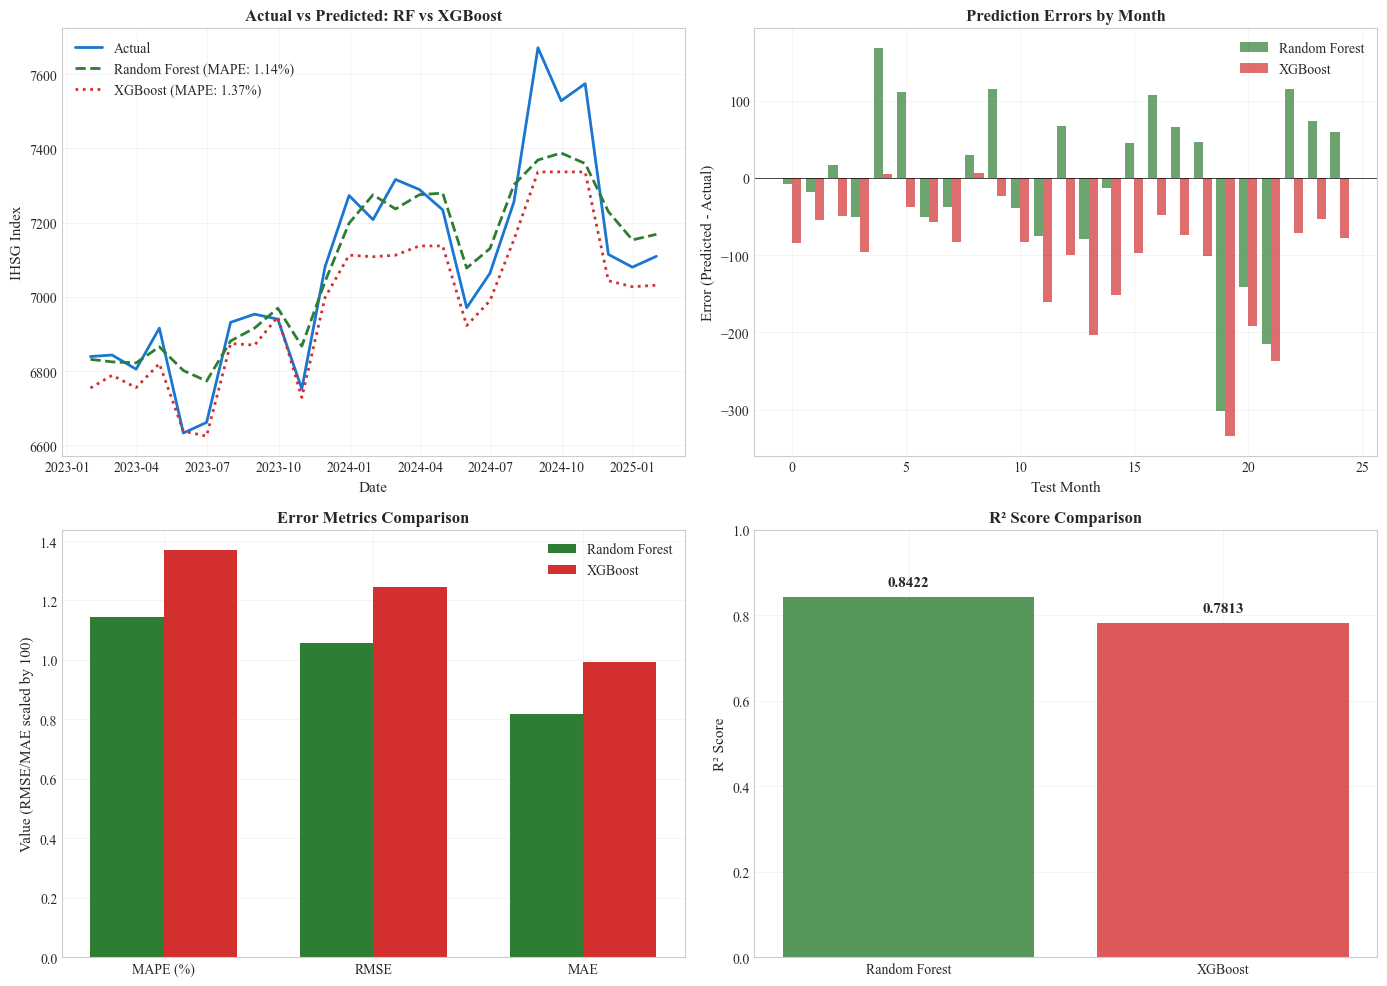

✅ Figure saved: model_comparison_rf_xgb.png (300 DPI)


In [132]:
# =========================================================================
# VISUALIZATION: RANDOM FOREST vs XGBOOST
# =========================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predictions (Both Models)
ax1 = axes[0, 0]
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=2)
ax1.plot(predictions.time_index, predictions.values(), 
         label=f'Random Forest (MAPE: {mape_score:.2f}%)', 
         color=COLORS['IHSG'], linewidth=2, linestyle='--')
ax1.plot(xgb_predictions.time_index, xgb_predictions.values(), 
         label=f'XGBoost (MAPE: {xgb_mape:.2f}%)', 
         color=COLORS['predicted'], linewidth=2, linestyle=':')
ax1.set_title('Actual vs Predicted: RF vs XGBoost', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Prediction Errors
ax2 = axes[0, 1]
rf_errors = (predictions.values().flatten() - test_actual.values().flatten())
xgb_errors = (xgb_predictions.values().flatten() - test_actual.values().flatten())
ax2.bar(np.arange(len(rf_errors)) - 0.2, rf_errors, 0.4, 
        label='Random Forest', color=COLORS['IHSG'], alpha=0.7)
ax2.bar(np.arange(len(xgb_errors)) + 0.2, xgb_errors, 0.4, 
        label='XGBoost', color=COLORS['predicted'], alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Prediction Errors by Month', fontsize=12, fontweight='bold')
ax2.set_xlabel('Test Month')
ax2.set_ylabel('Error (Predicted - Actual)')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.grid(True, alpha=0.3)

# Plot 3: Metrics Comparison Bar Chart
ax3 = axes[1, 0]
metrics = ['MAPE (%)', 'RMSE', 'MAE']
rf_values = [mape_score, rmse_score/100, mae_score/100]  # Scaled for visibility
xgb_values = [xgb_mape, xgb_rmse/100, xgb_mae/100]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, rf_values, width, label='Random Forest', color=COLORS['IHSG'])
bars2 = ax3.bar(x + width/2, xgb_values, width, label='XGBoost', color=COLORS['predicted'])
ax3.set_ylabel('Value (RMSE/MAE scaled by 100)')
ax3.set_title('Error Metrics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: R² Comparison
ax4 = axes[1, 1]
models = ['Random Forest', 'XGBoost']
r2_values = [r2, xgb_r2]
colors_bar = [COLORS['IHSG'], COLORS['predicted']]
bars = ax4.bar(models, r2_values, color=colors_bar, alpha=0.8)
ax4.set_ylabel('R² Score')
ax4.set_title('R² Score Comparison', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
for bar, val in zip(bars, r2_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison_rf_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model_comparison_rf_xgb.png (300 DPI)")